# KIDNEY DISEASE DETECTION

Lien du projet sur google collab:
https://colab.research.google.com/drive/1Uy_KicJvhUZnA_f0ysyQuktcF27PWmCd#scrollTo=xCAqpV6njhuW

## Importing the librairies

In [3]:
import time

# Start timer
start_time = time.time()

In [4]:
import os
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.src.utils import to_categorical
from keras.src.utils import load_img, img_to_array
import tensorflow as tf
from keras.src.models import Sequential
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
import cv2


## Loading the dataset

In [5]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from keras.src.utils import to_categorical

# Specifying the directory containing the dataset and the folder names for each class
data_dir = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'   
categories = ['Cyst', 'Normal', 'Stone', 'Tumor']   

def preprocess_images(data_dir):
    data = []
    targets = []
    print("Starting image processing...")

    for idx, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        if not os.path.exists(category_path):
            raise FileNotFoundError(f"Folder {category_path} is missing.")

        print(f"Processing images in category: {category}")
        files = os.listdir(category_path)

        for file in files:
            file_path = os.path.join(category_path, file)
            try:
                # Open the image and resize it to 32x32
                img = Image.open(file_path).resize((32, 32))
                #Convert image to a graysacle
                grey_img=img.convert('L')
                # Normalize pixel values
                img_array = np.array(grey_img) / 255.0

                # Reshape to include a single channel (32, 32, 1)
                img_array = img_array.reshape(32, 32, 1)

                data.append(img_array)
                targets.append(idx)  # Assign the class index as the label
            except Exception as error:
                print(f"Failed to process {file_path}: {error}")
                continue

    return np.array(data), np.array(targets)

# Load and preprocess the dataset
images, labels = preprocess_images(data_dir)

# Display dataset details
print(f"Number of images: {images.shape[0]}")
print(f"Image dimensions: {images.shape[1:]}")
print(f"Number of labels: {len(labels)}")

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=len(categories))

# Split the data into training, validation, and test subsets
X_train, X_intermediate, y_train, y_intermediate = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_intermediate, y_intermediate, test_size=0.5, random_state=42)

# Display the sizes of the splits
print("Dataset partitioning:")
print(f"Training data: {X_train.shape}, {y_train.shape}")
print(f"Validation data: {X_val.shape}, {y_val.shape}")
print(f"Testing data: {X_test.shape}, {y_test.shape}")

Starting image processing...
Processing images in category: Cyst
Processing images in category: Normal
Processing images in category: Stone
Processing images in category: Tumor
Number of images: 3958
Image dimensions: (32, 32, 1)
Number of labels: 3958
Dataset partitioning:
Training data: (2770, 32, 32, 1), (2770, 4)
Validation data: (594, 32, 32, 1), (594, 4)
Testing data: (594, 32, 32, 1), (594, 4)


In [6]:
train_dir = Path('CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

In [7]:
# Get the path to the normal and pneumonia sub-directories
Normal_Cases_dir = train_dir / 'Normal'
Cyst_Cases_dir = train_dir / 'Cyst'
Stone_Cases_dir = train_dir / 'Stone'
Tumor_Cases_dir = train_dir / 'Tumor'

In [8]:
# Getting the list of all the images
Normal_Cases = Normal_Cases_dir.glob('*.jpg')
Cyst_Cases = Cyst_Cases_dir.glob('*.jpg')
Stone_Cases = Stone_Cases_dir.glob('*.jpg')
Tumor_Cases = Tumor_Cases_dir.glob('*.jpg')

In [9]:
# Initialize X_train as an empty list
X_train = []

# Labeling the Cyst case as 0
for img in Cyst_Cases:
    X_train.append((img, 0))

# Labeling the Normal case as 1
for img in Normal_Cases:
    X_train.append((img, 1))

# Labeling the Stone case as 2
for img in Stone_Cases:
    X_train.append((img, 2))

# Labeling the Tumor case as 3
for img in Tumor_Cases:
    X_train.append((img, 3))

# If you need to convert X_train into a numpy array later
X_train = np.array(X_train)

# Available Dataset (Plotting Graph)

In [10]:
# Count the values of the original training labels
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)  # Using np.argmax to convert one-hot to single labels
cases_count_original = dict(zip(unique, counts))  # Creating a dictionary for labels and counts

# Display the counts
cases_count_original

{0: 762, 1: 1227, 2: 309, 3: 472}

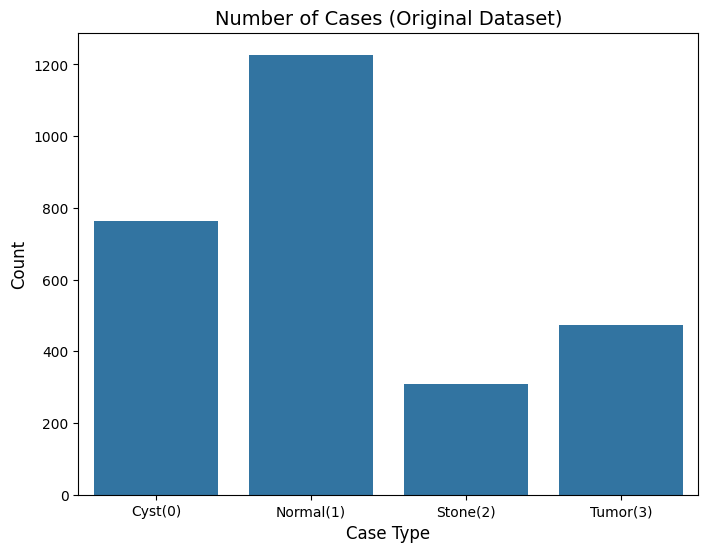

In [11]:
# Plotting the Graph for the original dataset
plt.figure(figsize=(8, 6))  # Set the size of the graph
sns.barplot(x=list(cases_count_original.keys()), y=list(cases_count_original.values()))
plt.title('Number of Cases (Original Dataset)', fontsize=14)
plt.xlabel('Case Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count_original.keys())), ['Cyst(0)', 'Normal(1)', 'Stone(2)', 'Tumor(3)'])
plt.show()

### Affichage le nombre d'images par catégorie

In [12]:
import os
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt

# Répertoire racine
root_dir = './CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Initialiser un dictionnaire pour les chemins d'images par catégorie
image_paths = defaultdict(list)

# Parcourir les sous-dossiers et charger les fichiers d'images
for category in os.listdir(root_dir):
    category_path = os.path.join(root_dir, category)
    if os.path.isdir(category_path):  # Vérifier si c'est un dossier
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if os.path.isfile(file_path):  # Vérifier si c'est un fichier
                image_paths[category].append(file_path)

# Afficher le nombre d'images par catégorie
for category, paths in image_paths.items():
    print(f"{category}: {len(paths)} images")

Cyst: 1124 images
Normal: 1738 images
Stone: 425 images
Tumor: 671 images


### Vérification les dimensions des images

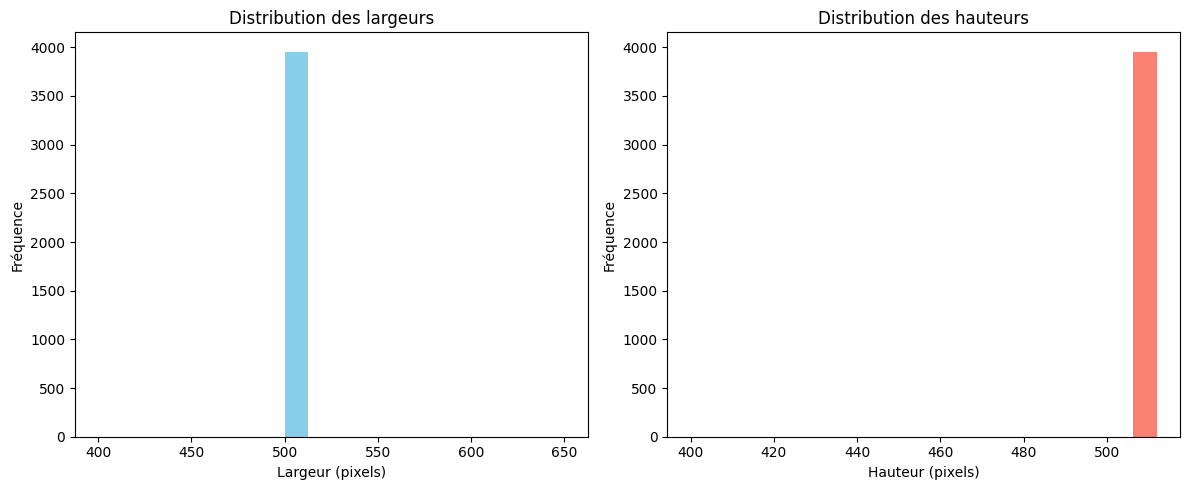

Dimensions uniques : {(650, 450), (400, 400), (512, 512)}


In [13]:
# Vérifier les dimensions des images
image_shapes = []

for category, paths in image_paths.items():
    for path in paths:
        try:
            with Image.open(path) as img:
                image_shapes.append(img.size)
        except Exception as e:
            print(f"Erreur avec l'image {path}: {e}")

# Distribution des largeurs et hauteurs
if image_shapes:  # Vérifier que la liste n'est pas vide
    widths, heights = zip(*image_shapes)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='skyblue')
    plt.title("Distribution des largeurs")
    plt.xlabel("Largeur (pixels)")
    plt.ylabel("Fréquence")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='salmon')
    plt.title("Distribution des hauteurs")
    plt.xlabel("Hauteur (pixels)")
    plt.ylabel("Fréquence")

    plt.tight_layout()
    plt.show()

    print(f"Dimensions uniques : {set(image_shapes)}")
else:
    print("Aucune image chargée correctement.")

### Vérification les formats des images

In [14]:
# Vérifier les formats des images
formats = []

for category, paths in image_paths.items():
    for path in paths:
        try:
            with Image.open(path) as img:
                formats.append(img.format)
        except Exception as e:
            print(f"Erreur avec l'image {path}: {e}")

# Compter les formats
from collections import Counter
format_counts = Counter(formats)
print("Répartition des formats d'images :", format_counts)

Répartition des formats d'images : Counter({'JPEG': 3958})


### Visualisation des pixels d'une image (niveaux de gris)

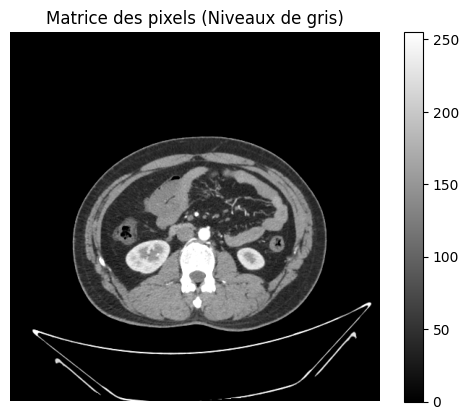

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Exemple de chemin pour une image spécifique
example_img_path = os.path.join(root_dir, 'Normal', 'Normal- (980).jpg')  

# Charger et afficher l'image en niveaux de gris
image = Image.open(example_img_path).convert("L")  # Convertir en niveaux de gris
image_array = np.array(image)

plt.imshow(image_array, cmap='gray')
plt.colorbar()
plt.title("Matrice des pixels (Niveaux de gris)")
plt.axis('off')
plt.show()

### Histogramme des couleurs

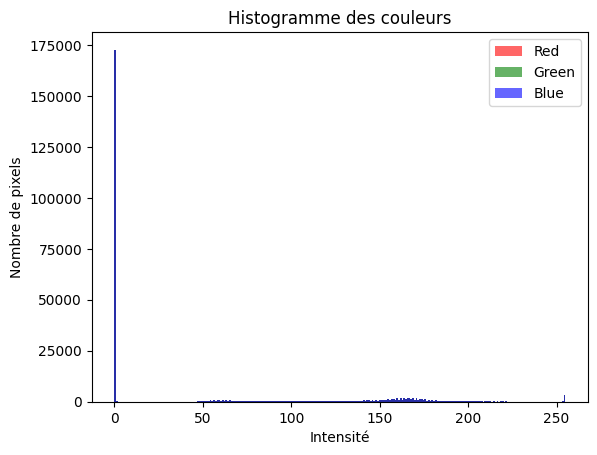

In [16]:
def plot_color_histogram(image_path):
    """
    Affiche un histogramme des couleurs (Rouge, Vert, Bleu) pour une image donnée.
    """
    image = Image.open(image_path).convert("RGB")  # Charger l'image en couleur
    image_array = np.array(image)

    colors = ['Red', 'Green', 'Blue']
    for i, color in enumerate(colors):
        plt.hist(image_array[..., i].flatten(), bins=256, alpha=0.6, label=color, color=color.lower())

    plt.title("Histogramme des couleurs")
    plt.xlabel("Intensité")
    plt.ylabel("Nombre de pixels")
    plt.legend()
    plt.show()

# Exemple d'utilisation pour une image du dataset
example_img_path = os.path.join(root_dir, 'Tumor', 'Tumor- (584).jpg')  
plot_color_histogram(example_img_path)

# CT Scanned Images Available 

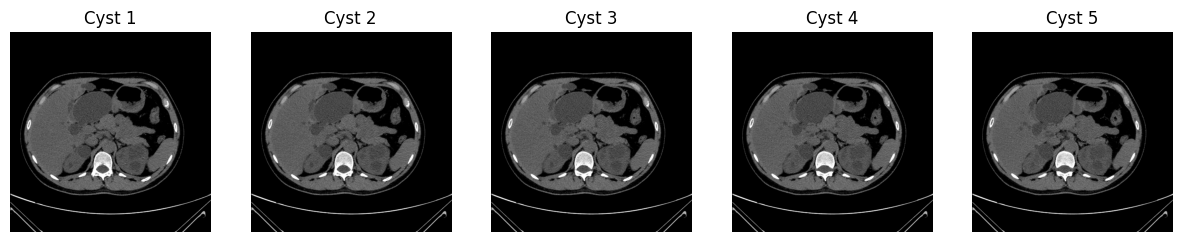

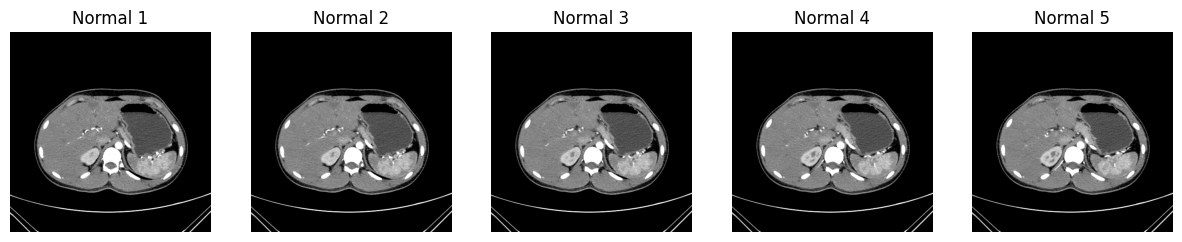

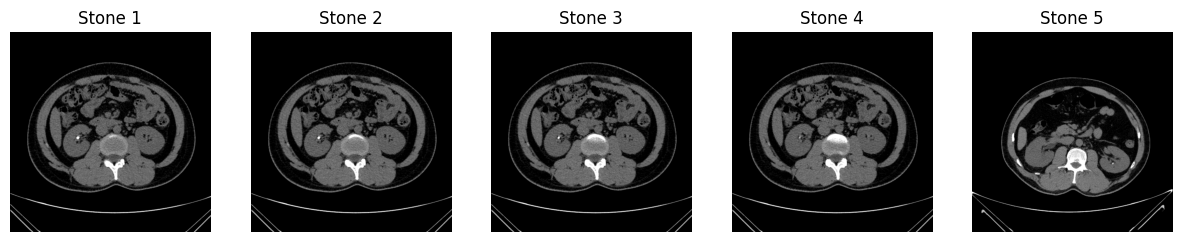

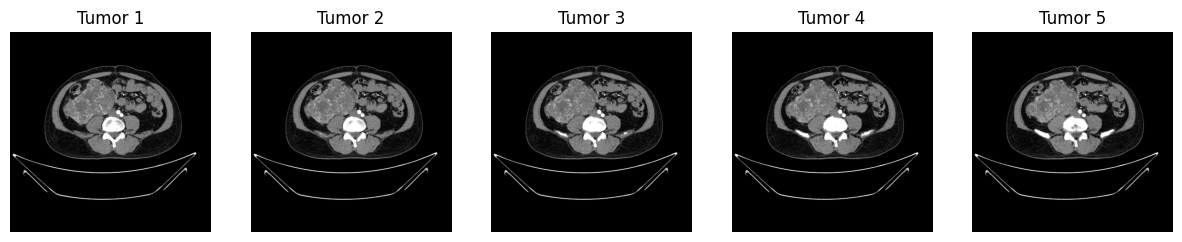

In [17]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the root directory where the images are stored
root_dir = './CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'  
# Define the categories and their corresponding prefixes
categories = {
    'Cyst': 'Cyst-',
    'Normal': 'Normal-',
    'Stone': 'Stone-',
    'Tumor': 'Tumor-'
}

# Function to display images from a given category
def display_images_from_category(category_name, prefix):
    category_path = os.path.join(root_dir, category_name)
    
    # List the image files that match the category's prefix pattern and have numbers in parentheses
    image_files = [f for f in os.listdir(category_path) if f.startswith(prefix) and f.endswith(('png', 'jpg', 'jpeg')) and re.search(r'\(\d+\)', f)]
    
    # Check if images were found
    if not image_files:
        print(f"Aucune image trouvée pour {category_name} avec le préfixe {prefix}.")
        return
    
    # Sort images to display in a consistent order (if needed)
    image_files.sort()
    
    # Display a few images
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i < len(image_files):
            img_path = os.path.join(category_path, image_files[i])
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            ax.set_title(f'{category_name} {i+1}')
        else:
            ax.axis('off')  # Hide remaining axes if not enough images
    plt.show()

# Display a few images from each category
for category_name, prefix in categories.items():
    display_images_from_category(category_name, prefix)

## Load the images

In [18]:
# Load the dataset images and labels
images, labels = preprocess_images(data_dir)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print statistics about the splits
print(f"Total images: {images.shape[0]}")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# At this point, X_train and y_train can be used for training
# X_val and y_val for validation during training
# X_test and y_test for final evaluation

Starting image processing...
Processing images in category: Cyst
Processing images in category: Normal
Processing images in category: Stone
Processing images in category: Tumor
Total images: 3958
Training set: (2770, 32, 32, 1), (2770,)
Validation set: (594, 32, 32, 1), (594,)
Test set: (594, 32, 32, 1), (594,)


# Solving Image Dataset Imblance Using SMOTE

In [19]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Check the original shape of X_train
print("Original shape of X_train:", X_train.shape)

# Ensure X_train is not empty
if X_train.size == 0:
    raise ValueError("X_train is empty! Please check your data loading pipeline.")

# Get the total number of rows in the training data
num_train_samples = len(X_train)

# Ensure the data has the correct number of features (not zero)
if X_train.shape[1] == 0:
    raise ValueError("X_train has no features. Please check the feature extraction process.")

# Reshape the training data from 4D to 2D (required for SMOTE)
X_train_reshaped = X_train.reshape(num_train_samples, -1)

# Check the new shape after reshaping
print("Shape after reshaping:", X_train_reshaped.shape)

# Apply SMOTE to balance the dataset
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reshaped, y_train)

# Reshape the balanced training data back to its original shape (4D)
X_train_balanced = X_train_balanced.reshape(-1, 32, 32, 1)

print("Original training dataset size:", X_train.shape[0])
print("Balanced training dataset size:", X_train_balanced.shape[0])
print("Original testing dataset size:", y_train.shape[0])
print("Balanced testing dataset size:", y_train_balanced.shape[0])

Original shape of X_train: (2770, 32, 32, 1)
Shape after reshaping: (2770, 1024)
Original training dataset size: 2770
Balanced training dataset size: 4908
Original testing dataset size: 2770
Balanced testing dataset size: 4908


# Balanced Dataset after using SMOTE

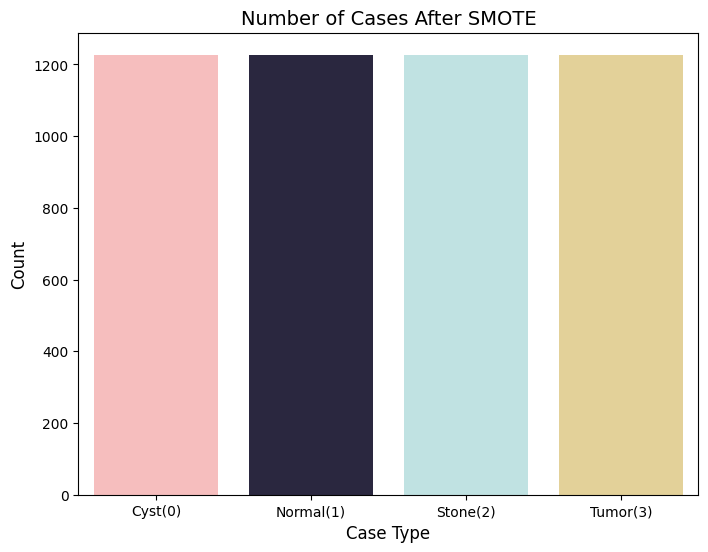

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count the values of the balanced labels
unique, counts = np.unique(y_train_balanced, return_counts=True)  # No need for np.argmax here
cases_count_balanced = dict(zip(unique, counts))  # Creating a dictionary for labels and counts

# Define custom colors for each category
custom_colors = ['#ffb5b5', '#272343', '#bae8e8', '#f0d78c']  

# Plotting the distribution of labels
plt.figure(figsize=(8, 6))  # Setting the size of the graph
sns.barplot(x=list(cases_count_balanced.keys()), 
            y=list(cases_count_balanced.values()), 
            hue=list(cases_count_balanced.keys()),  # Assign the hue to match the x values
            palette=custom_colors,  # Apply custom colors
            legend=False)  # Disable legend since it's not necessary

# Set titles and labels
plt.title('Number of Cases After SMOTE', fontsize=14)
plt.xlabel('Case Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set x-ticks for the labels
plt.xticks(range(len(cases_count_balanced)), ['Cyst(0)', 'Normal(1)', 'Stone(2)', 'Tumor(3)'])

# Display the plot
plt.show()

## Convert Integer labels to One-hot-encoded labels

In [21]:
# Update the number of classes based on your dataset
num_classes = len(set(labels))  # Automatically determine the number of unique classes

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Print shapes to verify
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (2770, 4)
y_val shape: (594, 4)
y_test shape: (594, 4)


In [22]:
print("Forme des données d'images (train):", X_train.shape)
print("Forme des labels (train):", y_train.shape)

print("Forme des données d'images (validation):", X_val.shape)
print("Forme des labels (validation):", y_val.shape)

print("Forme des données d'images (test):", X_test.shape)
print("Forme des labels (test):", y_test.shape)

Forme des données d'images (train): (2770, 32, 32, 1)
Forme des labels (train): (2770, 4)
Forme des données d'images (validation): (594, 32, 32, 1)
Forme des labels (validation): (594, 4)
Forme des données d'images (test): (594, 32, 32, 1)
Forme des labels (test): (594, 4)


## Data Distribution Visualisation

In [23]:
df = pd.read_csv('kidneyData.csv')
df.head(5)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


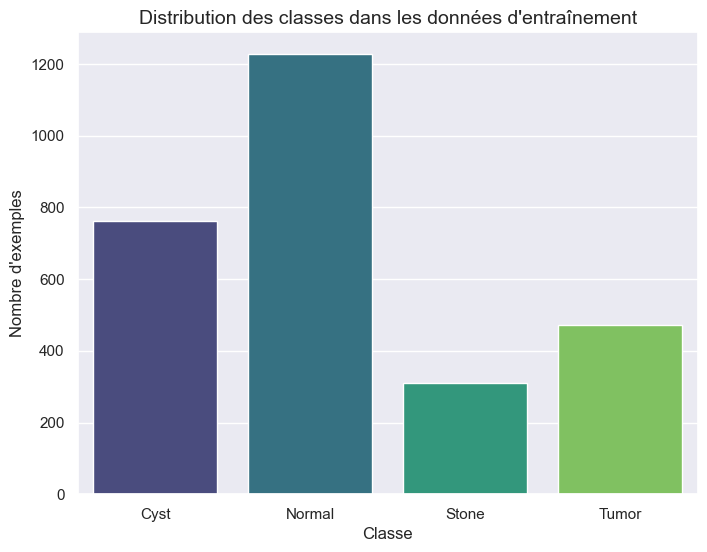

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your labels and classes are in `y_train`, `y_val`, or `y_test`
df = pd.DataFrame({'classname': ['Cyst', 'Normal', 'Stone', 'Tumor']})
df['count'] = [sum(y_train[:, i]) for i in range(y_train.shape[1])]

sns.set_theme(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='classname', y='count', data=df, hue='classname', palette="viridis", dodge=False)
plt.title("Distribution des classes dans les données d'entraînement", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre d'exemples", fontsize=12)
plt.legend([], [], frameon=False)  # Removes redundant legend
plt.show()

In [25]:
from sklearn.model_selection import train_test_split

# Charger les images et labels avec ta fonction load_images
train_images, train_labels = preprocess_images(data_dir)

# Diviser les données en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

Starting image processing...
Processing images in category: Cyst
Processing images in category: Normal
Processing images in category: Stone
Processing images in category: Tumor


## Splitting the data into training and validation

## Convert labels to one-hot encoding

In [26]:
# Afficher la forme des jeux de données finaux
print("Train images shape:", X_train.shape)
print("Validation images shape:", X_val.shape)
print("Train labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Train images shape: (3166, 32, 32, 1)
Validation images shape: (792, 32, 32, 1)
Train labels shape: (3166,)
Validation labels shape: (792,)


# The LeNet5 Model without Dropout

## Architecture of Model 1

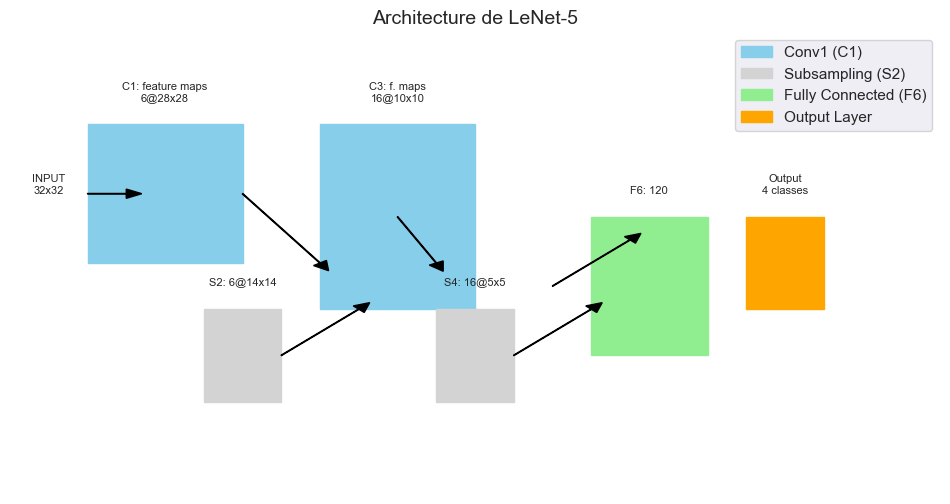

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_lenet5_architecture():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convolutional layers (C1, C3)
    ax.add_patch(patches.Rectangle((0.1, 0.5), 0.2, 0.3, color='skyblue', label='Conv1 (C1)'))
    ax.text(0.2, 0.85, 'C1: feature maps\n6@28x28', ha='center', fontsize=8)

    ax.add_patch(patches.Rectangle((0.4, 0.4), 0.2, 0.4, color='skyblue'))
    ax.text(0.5, 0.85, 'C3: f. maps\n16@10x10', ha='center', fontsize=8)
    
    # Subsampling layers (S2, S4)
    ax.add_patch(patches.Rectangle((0.25, 0.2), 0.1, 0.2, color='lightgray', label='Subsampling (S2)'))
    ax.text(0.3, 0.45, 'S2: 6@14x14', ha='center', fontsize=8)

    ax.add_patch(patches.Rectangle((0.55, 0.2), 0.1, 0.2, color='lightgray'))
    ax.text(0.6, 0.45, 'S4: 16@5x5', ha='center', fontsize=8)
    
    # Fully connected layers (F6)
    ax.add_patch(patches.Rectangle((0.75, 0.3), 0.15, 0.3, color='lightgreen', label='Fully Connected (F6)'))
    ax.text(0.825, 0.65, 'F6: 120', ha='center', fontsize=8)
    
    # Output layer
    ax.add_patch(patches.Rectangle((0.95, 0.4), 0.1, 0.2, color='orange', label='Output Layer'))
    ax.text(1.0, 0.65, 'Output\n4 classes', ha='center', fontsize=8)
    
    # Connections
    ax.arrow(0.3, 0.65, 0.1, -0.15, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.5, 0.6, 0.05, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.35, 0.3, 0.1, 0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.65, 0.3, 0.1, 0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.7, 0.45, 0.1, 0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    
    # Add annotations for input
    ax.text(0.05, 0.65, 'INPUT\n32x32', ha='center', fontsize=8)
    ax.arrow(0.1, 0.65, 0.05, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')
    
    # Final layout
    ax.axis('off')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 1)
    plt.title("Architecture de LeNet-5", fontsize=14)
    plt.legend(loc='upper right')
    plt.show()

draw_lenet5_architecture()

In [28]:
from keras.src.models import Sequential
from keras.src.layers import Conv2D, AveragePooling2D, Flatten, Dense, InputLayer

# Définir le modèle
model1 = Sequential([    
    # Première couche : Définir la forme d'entrée avec InputLayer
    InputLayer(shape=(32, 32, 1)),  # Définir la forme d'entrée 32x32x1
    
    # C1: Couche de convolution avec 6 filtres 5x5, activation ReLU
    Conv2D(6, (5, 5), activation='relu'),

    # S2: SubSampling (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),

    # C3: Deuxième couche de convolution avec 16 filtres 5x5, activation ReLU
    Conv2D(16, (5, 5), activation='relu'),

    # S4: SubSampling (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),

    # Aplatir pour passer aux couches denses
    Flatten(),

    # C5: Couche entièrement connectée avec 120 neurones
    Dense(120, activation='relu'),

    # F6: Couche entièrement connectée avec 84 neurones
    Dense(84, activation='relu'),

    # Couche de sortie avec 4 neurones (pour 4 classes de classification)
    Dense(4, activation='softmax')
])

# Afficher le résumé du modèle
model1.summary()

# Compiler le modèle
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,196 (239.05 KB)

 Trainable params: 61,196 (239.05 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [29]:
# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))

# Train the model
history1 = model1.fit(
    X_train,                # Training images
    y_train,                # One-hot encoded training labels
    validation_data=(X_val, y_val),  # Validation images and one-hot encoded labels
    epochs=20,              # Number of epochs
    batch_size=64           # Batch size
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4366 - loss: 1.2554 - val_accuracy: 0.6376 - val_loss: 0.9781
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6466 - loss: 0.8665 - val_accuracy: 0.8270 - val_loss: 0.5698
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7883 - loss: 0.5652 - val_accuracy: 0.8889 - val_loss: 0.3624
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8848 - loss: 0.3581 - val_accuracy: 0.9609 - val_loss: 0.2354
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9332 - loss: 0.2488 - val_accuracy: 0.9571 - val_loss: 0.1612
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9587 - loss: 0.1629 - val_accuracy: 0.9848 - val_loss: 0.0967
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9726 - loss: 0.1175 - val_accuracy: 0.9861 - val_loss: 0.0857
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9833 - loss: 0.0700 - val_accuracy: 0.9848 - val_loss

## Evaluating the model on the validation and test set




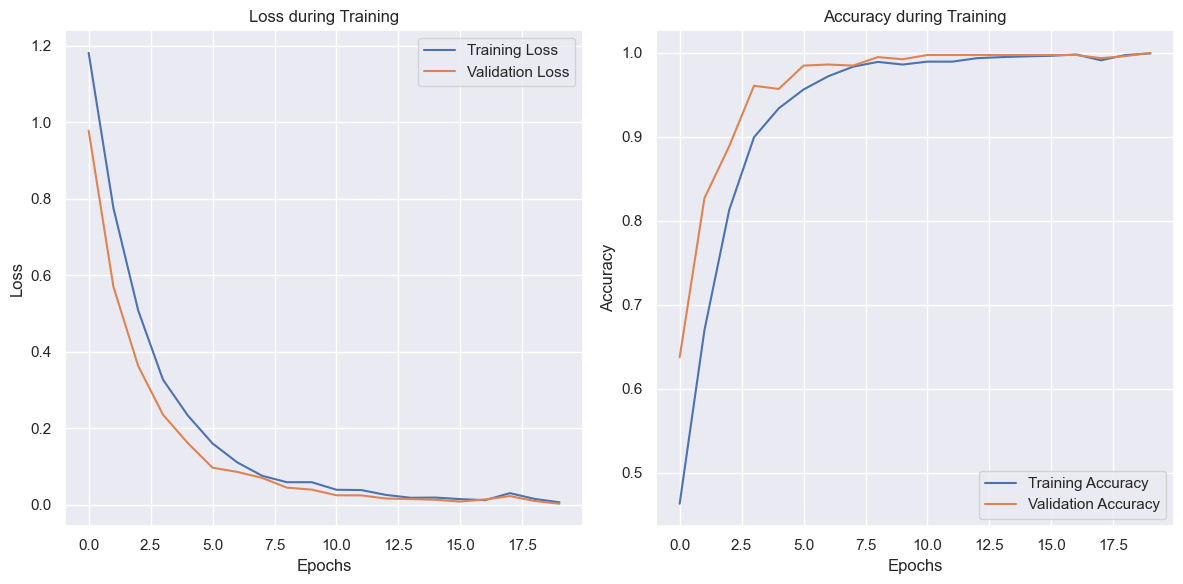

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0062
Test Accuracy: 99.83%


In [30]:
# Évaluer les performances du modèle

import matplotlib.pyplot as plt

# Extract loss and accuracy from training history
train_loss = history1.history['loss']
train_acc = history1.history['accuracy']
val_loss = history1.history['val_loss']
val_acc = history1.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss_model1, test_accuracy_model1 = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_model1 * 100:.2f}%")

In [31]:
val_loss_model1, val_accuracy_model1 = model1.evaluate(X_test, y_test)

print(f"Validation Loss: {val_loss_model1 * 100:.2f}%")
print(f"Validation Accuracy:{ val_accuracy_model1 * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0062 
Validation Loss: 0.49%
Validation Accuracy:99.83%


# The LeNet5 Model with Dropout
## Architecture of model 2



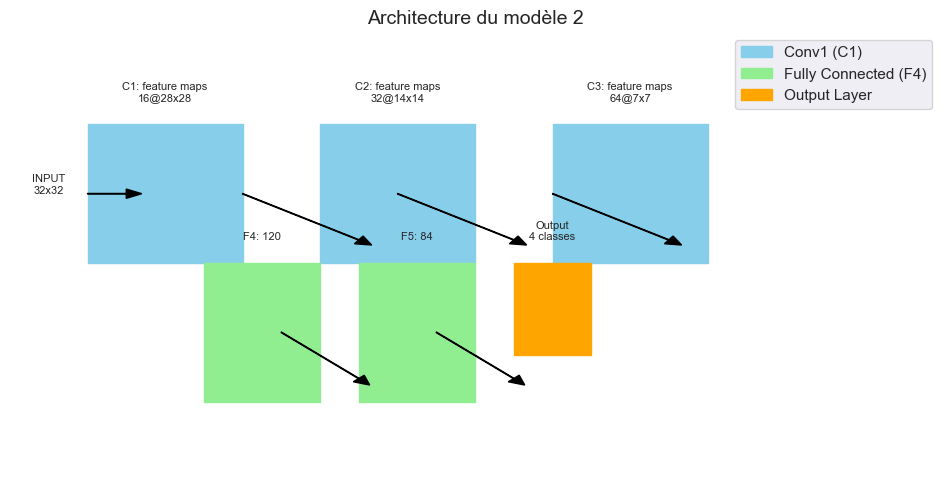

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_model_2_architecture():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convolutional layers (C1, C2, C3)
    ax.add_patch(patches.Rectangle((0.1, 0.5), 0.2, 0.3, color='skyblue', label='Conv1 (C1)'))
    ax.text(0.2, 0.85, 'C1: feature maps\n16@28x28', ha='center', fontsize=8)

    ax.add_patch(patches.Rectangle((0.4, 0.5), 0.2, 0.3, color='skyblue'))
    ax.text(0.5, 0.85, 'C2: feature maps\n32@14x14', ha='center', fontsize=8)
    
    ax.add_patch(patches.Rectangle((0.7, 0.5), 0.2, 0.3, color='skyblue'))
    ax.text(0.8, 0.85, 'C3: feature maps\n64@7x7', ha='center', fontsize=8)
    
    # Fully connected layers (F4, F5)
    ax.add_patch(patches.Rectangle((0.25, 0.2), 0.15, 0.3, color='lightgreen', label='Fully Connected (F4)'))
    ax.text(0.325, 0.55, 'F4: 120', ha='center', fontsize=8)

    ax.add_patch(patches.Rectangle((0.45, 0.2), 0.15, 0.3, color='lightgreen'))
    ax.text(0.525, 0.55, 'F5: 84', ha='center', fontsize=8)
    
    # Output layer
    ax.add_patch(patches.Rectangle((0.65, 0.3), 0.1, 0.2, color='orange', label='Output Layer'))
    ax.text(0.7, 0.55, 'Output\n4 classes', ha='center', fontsize=8)
    
    # Connections
    ax.arrow(0.3, 0.65, 0.15, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.5, 0.65, 0.15, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.7, 0.65, 0.15, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.35, 0.35, 0.1, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.55, 0.35, 0.1, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    
    # Add annotations for input
    ax.text(0.05, 0.65, 'INPUT\n32x32', ha='center', fontsize=8)
    ax.arrow(0.1, 0.65, 0.05, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')
    
    # Final layout
    ax.axis('off')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 1)
    plt.title("Architecture du modèle 2", fontsize=14)
    plt.legend(loc='upper right')
    plt.show()

draw_model_2_architecture()

In [33]:

model2 = Sequential([
    # C1: Couche de convolution avec 6 filtres 5x5, activation ReLU, entrée 32x32x1
    InputLayer(shape=(32, 32, 1)),  # Définir la forme d'entrée 32x32x1
    Conv2D(6, (5, 5), activation='relu'),

    # S2: Sous-échantillonnage (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),

    # C3: Deuxième couche de convolution avec 16 filtres 5x5, activation ReLU
    Conv2D(16, (5, 5), activation='relu'),

    # S4: Sous-échantillonnage (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),

    # Aplatir pour passer aux couches denses
    Flatten(),

    # C5: Couche entièrement connectée avec 120 neurones
    Dense(120, activation='relu'),

    Dropout(0.5),

    # F6: Couche entièrement connectée avec 84 neurones
    Dense(84, activation='relu'),

    Dropout(0.5),

    # Couche de sortie avec 4 neurones (pour 4 classes de classification)
    Dense(4, activation='softmax')
])

# Afficher le résumé du modèle
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,196 (239.05 KB)

 Trainable params: 61,196 (239.05 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
history2 = model2.fit(
    X_train,                # Training images
    y_train,                # One-hot encoded training labels
    validation_data=(X_val, y_val),  # Validation images and one-hot encoded labels
    epochs=20,              # Number of epochs
    batch_size=64           # Batch size
)

Epoch 1/20


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4174 - loss: 1.2980 - val_accuracy: 0.5631 - val_loss: 1.0853
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5821 - loss: 1.0624 - val_accuracy: 0.7045 - val_loss: 0.7706
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6883 - loss: 0.7896 - val_accuracy: 0.8093 - val_loss: 0.5270
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7482 - loss: 0.6054 - val_accuracy: 0.8598 - val_loss: 0.3748
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8257 - loss: 0.4775 - val_accuracy: 0.8662 - val_loss: 0.3234
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8633 - loss: 0.3887 - val_accuracy: 0.9457 - val_loss: 0.1836
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9053 - loss: 0.2917 - val_accuracy: 0.9710 - val_loss: 0.1283
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9266 - loss: 0.2357 - val_accuracy: 0.9798 - val_loss: 0.08

# Évaluer les performances du modèle


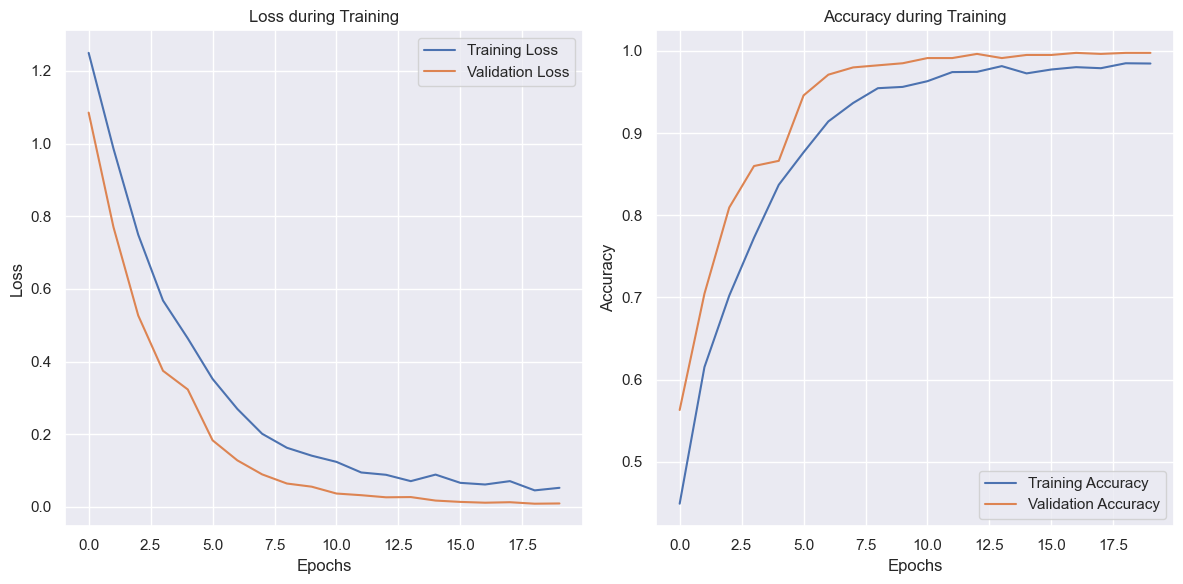

In [36]:
# Évaluer les performances du modèle

import matplotlib.pyplot as plt

# Extract loss and accuracy from training history
train_loss = history2.history['loss']
train_acc = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_acc = history2.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Évaluer les performances du modèle
test_loss_model2, test_accuracy_model2 = model2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_model2 * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0042 
Test Accuracy: 99.83%


In [38]:
# Évaluer les performances du modèle sur la validation
val_loss_model2, val_accuracy_model2 = model2.evaluate(X_val, y_val)

print(f"Validation Loss: {val_loss_model2:.2f}")
print(f"Validation Accuracy: {val_accuracy_model2 * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9952 - loss: 0.0136
Validation Loss: 0.01
Validation Accuracy: 99.75%


# Other CNN model architectures with more convolutional layers and Dropout layers
## Model 3 architecture

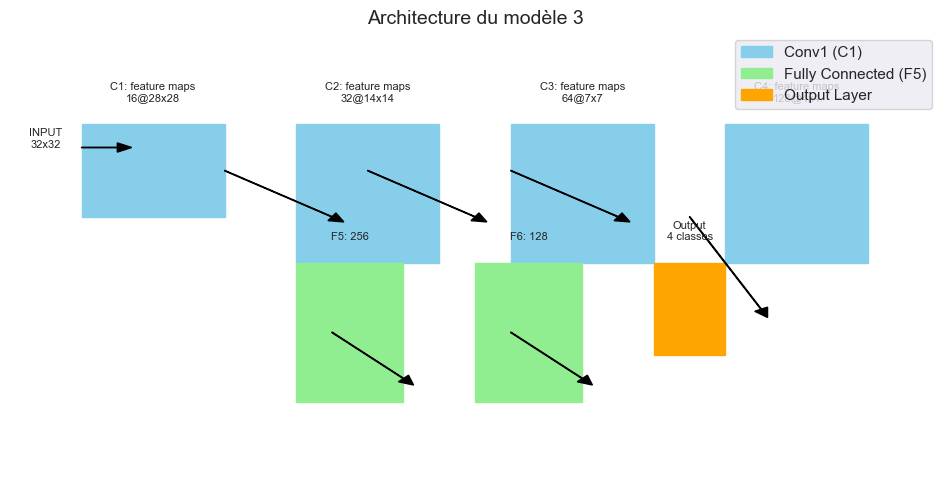

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_model_3_architecture():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Convolutional layers (C1, C2, C3, C4)
    ax.add_patch(patches.Rectangle((0.1, 0.6), 0.2, 0.2, color='skyblue', label='Conv1 (C1)'))
    ax.text(0.2, 0.85, 'C1: feature maps\n16@28x28', ha='center', fontsize=8)

    ax.add_patch(patches.Rectangle((0.4, 0.5), 0.2, 0.3, color='skyblue'))
    ax.text(0.5, 0.85, 'C2: feature maps\n32@14x14', ha='center', fontsize=8)
    
    ax.add_patch(patches.Rectangle((0.7, 0.5), 0.2, 0.3, color='skyblue'))
    ax.text(0.8, 0.85, 'C3: feature maps\n64@7x7', ha='center', fontsize=8)
    
    ax.add_patch(patches.Rectangle((1.0, 0.5), 0.2, 0.3, color='skyblue'))
    ax.text(1.1, 0.85, 'C4: feature maps\n128@4x4', ha='center', fontsize=8)
    
    # Fully connected layers (F5, F6)
    ax.add_patch(patches.Rectangle((0.4, 0.2), 0.15, 0.3, color='lightgreen', label='Fully Connected (F5)'))
    ax.text(0.475, 0.55, 'F5: 256', ha='center', fontsize=8)

    ax.add_patch(patches.Rectangle((0.65, 0.2), 0.15, 0.3, color='lightgreen'))
    ax.text(0.725, 0.55, 'F6: 128', ha='center', fontsize=8)
    
    # Output layer
    ax.add_patch(patches.Rectangle((0.9, 0.3), 0.1, 0.2, color='orange', label='Output Layer'))
    ax.text(0.95, 0.55, 'Output\n4 classes', ha='center', fontsize=8)
    
    # Connections
    ax.arrow(0.3, 0.7, 0.15, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.5, 0.7, 0.15, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.7, 0.7, 0.15, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.95, 0.6, 0.1, -0.2, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.45, 0.35, 0.1, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.7, 0.35, 0.1, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    
    # Add annotations for input
    ax.text(0.05, 0.75, 'INPUT\n32x32', ha='center', fontsize=8)
    ax.arrow(0.1, 0.75, 0.05, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')
    
    # Final layout
    ax.axis('off')
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    plt.title("Architecture du modèle 3", fontsize=14)
    plt.legend(loc='upper right')
    plt.show()

draw_model_3_architecture()

In [40]:
model3 = Sequential([
    # Première couche : Définir la forme d'entrée avec InputLayer
    InputLayer(shape=(32, 32, 1)),  # Définir la forme d'entrée 32x32x1
    
    # C1: Couche de convolution avec 32 filtres 3x3, activation ReLU
    Conv2D(32, (3, 3), activation='relu'),
    
    # Dropout après la première couche convolutive
    Dropout(0.2),

    # C2: Couche de convolution avec 64 filtres 3x3, activation ReLU
    Conv2D(64, (3, 3), activation='relu'),
    # Sous-échantillonnage (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # C3: Couche de convolution avec 128 filtres 3x3, activation ReLU
    Conv2D(128, (3, 3), activation='relu'),
    # Sous-échantillonnage (AveragePooling) 2x2
    AveragePooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # C4: Couche de convolution avec 256 filtres 3x3, activation ReLU
    Conv2D(256, (3, 3), activation='relu'),
    Dropout(0.4),

    # Aplatir pour passer aux couches entièrement connectées
    Flatten(),

    # C5: Couche entièrement connectée avec 512 neurones
    Dense(512, activation='relu'),
    Dropout(0.5),

    # F6: Couche entièrement connectée avec 256 neurones
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Couche de sortie avec 4 neurones (pour 4 classes de classification)
    Dense(4, activation='softmax')
])

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
# Afficher le résumé du modèle
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 14, 14, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 6, 6, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,617,860 (9.99 MB)

 Trainable params: 2,617,860 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Entraîner le modèle
history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

Epoch 1/20


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.4546 - loss: 1.2263 - val_accuracy: 0.6553 - val_loss: 0.8928
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6533 - loss: 0.8914 - val_accuracy: 0.7210 - val_loss: 0.6454
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7046 - loss: 0.7010 - val_accuracy: 0.8636 - val_loss: 0.4025
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7992 - loss: 0.4936 - val_accuracy: 0.9280 - val_loss: 0.2394
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.8828 - loss: 0.3121 - val_accuracy: 0.9672 - val_loss: 0.1122
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9320 - loss: 0.1910 - val_accuracy: 0.9912 - val_loss: 0.0343
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9702 - loss: 0.0892 - val_accuracy: 0.9874 - val_loss: 0.0307
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9786 - loss: 0.0739 - val_accuracy: 0.9975 - val

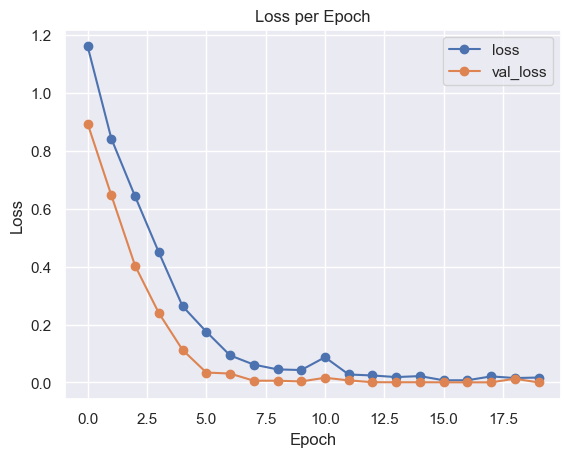

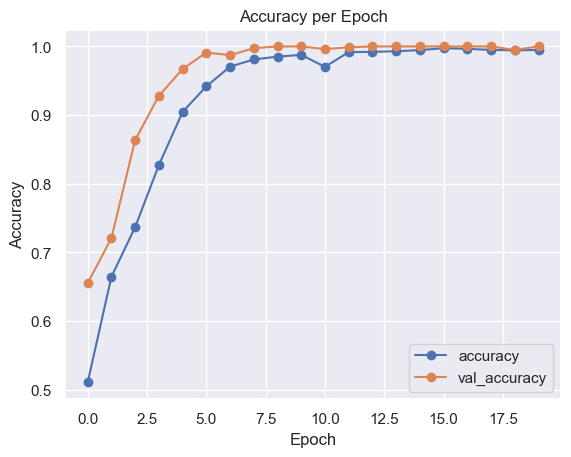

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir l'historique en DataFrame
history3= pd.DataFrame(history3.history)

# Tracer les courbes d'entraînement et de validation
history3[['loss', 'val_loss']].plot(title='Loss per Epoch', xlabel='Epoch', ylabel='Loss', marker='o')
history3[['accuracy', 'val_accuracy']].plot(title='Accuracy per Epoch', xlabel='Epoch', ylabel='Accuracy', marker='o')

plt.show()


In [44]:
# Évaluer les performances du modèle
test_loss_model3, test_accuracy_model3 = model3.evaluate(X_train, y_train)
print(f"Test Accuracy: {test_accuracy_model3 * 100:.2f}%")

99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 1.1926e-04
Test Accuracy: 100.00%


In [45]:
# Évaluer les performances du modèle sur la validation
val_loss_model3, val_accuracy_model3 = model3.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss_model3 * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_model3 * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 9.2102e-05
Validation Loss: 0.01%
Validation Accuracy: 100.00%


# Comparaison entre les 3 modéles

In [46]:
import pandas as pd
# Dictionnaire contenant les résultats
results = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Test Accuracy': [test_accuracy_model1, test_accuracy_model2, test_accuracy_model3],
    'Validation Accuracy': [val_accuracy_model1, val_accuracy_model2, val_accuracy_model3],
    'Test Loss': [test_loss_model1, test_loss_model2, test_loss_model3],
    'Validation Loss': [val_loss_model1, val_loss_model2, val_loss_model3],
}

# Convertir les colonnes de précision en pourcentage
results['Validation Accuracy'] = [acc * 100 for acc in results['Validation Accuracy']]
results['Test Accuracy'] = [acc * 100 for acc in results['Test Accuracy']]

# Créer un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)

# Afficher les valeurs en pourcentage avec 2 décimales
pd.options.display.float_format = '{:,.2f}%'.format
print(results_df)


     Model  Test Accuracy  Validation Accuracy  Test Loss  Validation Loss
0  Model 1         99.83%               99.83%      0.00%            0.00%
1  Model 2         99.83%               99.75%      0.01%            0.01%
2  Model 3        100.00%              100.00%      0.00%            0.00%


## Confusion Matrix

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


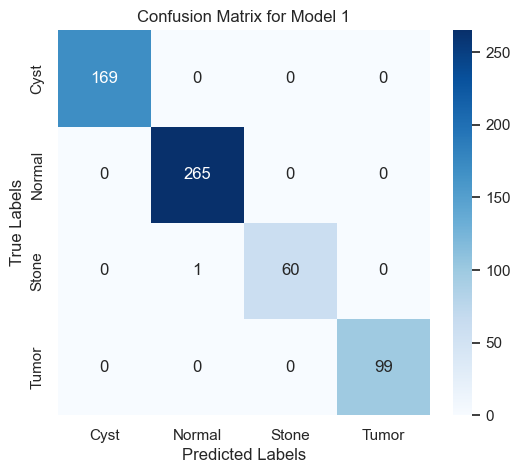

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


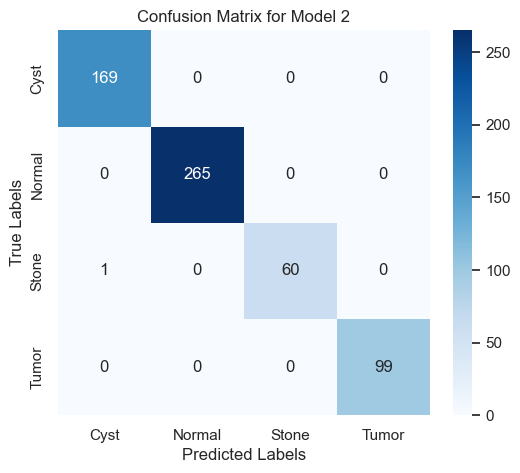

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


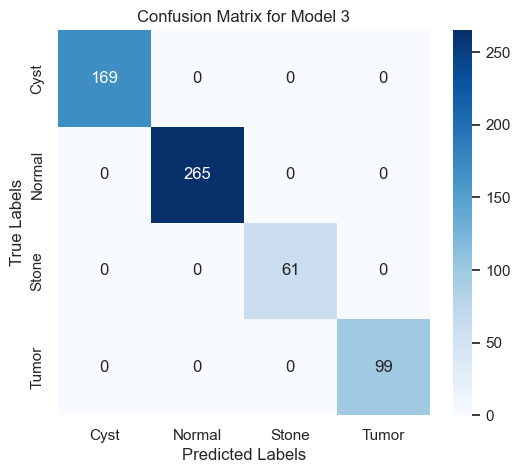

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Predictions and confusion matrix for model1
y_pred_model1 = model1.predict(X_test)
plot_confusion_matrix(y_test, y_pred_model1, "Model 1")

# Predictions and confusion matrix for model2
y_pred_model2 = model2.predict(X_test)
plot_confusion_matrix(y_test, y_pred_model2, "Model 2")

# Predictions and confusion matrix for model3
y_pred_model3 = model3.predict(X_test)
plot_confusion_matrix(y_test, y_pred_model3, "Model 3")


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming you have 3 models and their predictions:
# y_pred_model1, y_pred_model2, y_pred_model3

# Convert predictions to class labels (if they are probabilities)
y_pred_model1 = np.argmax(y_pred_model1, axis=1)
y_pred_model2 = np.argmax(y_pred_model2, axis=1)
y_pred_model3 = np.argmax(y_pred_model3, axis=1)

# Ensure y_test is also in the correct format
y_test = np.argmax(y_test, axis=1)

# Calculate metrics for Model 1
precision_model1 = precision_score(y_test, y_pred_model1, average='macro')
recall_model1 = recall_score(y_test, y_pred_model1, average='macro')
f1_model1 = f1_score(y_test, y_pred_model1, average='macro')

# Calculate metrics for Model 2
precision_model2 = precision_score(y_test, y_pred_model2, average='macro')
recall_model2 = recall_score(y_test, y_pred_model2, average='macro')
f1_model2 = f1_score(y_test, y_pred_model2, average='macro')

# Calculate metrics for Model 3
precision_model3 = precision_score(y_test, y_pred_model3, average='macro')
recall_model3 = recall_score(y_test, y_pred_model3, average='macro')
f1_model3 = f1_score(y_test, y_pred_model3, average='macro')

# Print the results
print(f"Model 1 - Precision: {precision_model1}, Recall: {recall_model1}, F1 Score: {f1_model1}")
print(f"Model 2 - Precision: {precision_model2}, Recall: {recall_model2}, F1 Score: {f1_model2}")
print(f"Model 3 - Precision: {precision_model3}, Recall: {recall_model3}, F1 Score: {f1_model3}")


Model 1 - Precision: 0.9990601503759399, Recall: 0.9959016393442623, F1 Score: 0.997463074504677
Model 2 - Precision: 0.9985294117647059, Recall: 0.9959016393442623, F1 Score: 0.997196421170677
Model 3 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0


In [49]:
import numpy as np
from keras.src.utils import load_img, img_to_array

# Mapping class indices to disease labels
class_labels = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

def predict_disease(model, image_path):
    """
    Predicts the disease type for a given input image.

    Parameters:
    - model: Trained model for prediction.
    - image_path: Path to the input image.

    Returns:
    - Predicted disease label.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(32, 32), color_mode='grayscale')  # Resize to 32x32 and grayscale
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class with the highest probability

    # Return the corresponding disease label
    return class_labels[predicted_class]

# Example usage
image_path='CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (562).jpg'
img = cv2.imread(str(image_path))

## Using the Model 1
predicted_disease_m1 = predict_disease(model1, image_path)
print(f"Using model 1: The predicted disease is: {predicted_disease_m1}")

## Using the Model 2
predicted_disease_m2 = predict_disease(model2, image_path)
print(f"Using model 2: The predicted disease is: {predicted_disease_m2}")

## Using the Model 3
predicted_disease_m3 = predict_disease(model3, image_path)
print(f"Using model 3: The predicted disease is: {predicted_disease_m3}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Using model 1: The predicted disease is: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Using model 2: The predicted disease is: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Using model 3: The predicted disease is: Tumor


In [50]:
# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Notebook executed in {elapsed_time:.2f} seconds.")

Notebook executed in 248.50 seconds.


In [51]:
!pip install pyyaml h5py


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
import tensorflow as tf
tf.keras.models.save_model(model1,'my_model2.hdf5')

In [54]:
!pip install streamlit


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
%%writefile app.py
# Save this file as `app.py`
import streamlit as st
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np

# Load model
@st.cache(allow_output_mutation=True)
def load_model():
    model = tf.keras.models.load_model('my_model2.hdf5')
    return model

model = load_model()

# Class labels (update these with your actual class names)
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor'] # Replace with actual class names

# Title and description
st.title("Kidney Scan Classification")
st.write("Upload a Kidney scan image to predict its class.")

# File uploader
file = st.file_uploader("Choose an image file", type=["jpg", "png"])

def preprocess_image(image_data, target_size):
    # Resize and convert to grayscale
    image = image_data.resize(target_size)
    image = image.convert('L')  # Convert to grayscale
    # Normalize and reshape
    image = np.asarray(image) / 255.0
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)   # Add batch dimension
    return image

# Prediction logic
if file is not None:
    image = Image.open(file)
    st.image(image, caption="Uploaded Image", use_container_width=True)

    if st.button("Predict"):
        with st.spinner("Predicting..."):
            target_size = (32, 32)
            preprocessed_image = preprocess_image(image,target_size)
            predictions = model.predict(preprocessed_image)
            score = tf.nn.softmax(predictions[0])

            # Display result
            predicted_class = class_names[np.argmax(score)]
            confidence = 100 * np.max(score)

            st.success(f"This image most likely belongs to **{predicted_class}**.")
else:
    st.text("Please upload an image file.")

Overwriting app.py


In [20]:
!streamlit run app.py

^C


## Pour aller plus loin
-> lien du projet sur google collab:
https://colab.research.google.com/drive/1Uy_KicJvhUZnA_f0ysyQuktcF27PWmCd#scrollTo=xCAqpV6njhuW